# 1 Introducción

En este notebook se va a llevar un modelado de topics identificando los principales temas que aparecen en reviews de Amazon correspondiente a cinco categorías diferentes.

El notebook comienza con la construcción de una dataset con información unificada y balanceada proveniente de cada una de las cinco categorías. Seguidamente se realizará un análsis básico exploratorio de datos, para, a continuación, procesar dicho dataset con el fin seleccionar los mejores modelos. De éstos, se elegirán dos y se estudiarán los tokens de los mismos y se verificará si se puede deducir los topics de cada modelo. 

Los datos utilizados en este notebook también se utilizan en el notebook de análisis de sentimiento.

## 1.1 Funciones y librerías generales

In [1]:
# Librerías más usadas a lo largo del notebook. 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from nltk.stem import WordNetLemmatizer

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim


cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
import warnings
warnings.filterwarnings('ignore')

# Por defecto mostramos todas las columnas y filas de los datasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Librerías para análisis de sentimiento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

# 2 Carga de datos para modelado de topics y análisis de sentimiento

Los datos que se van a procesar para el modelado de topics y análisis de sentimiento se obtienen de reviews de Amazon localizadas en http://jmcauley.ucsd.edu/data/amazon/. Para agilizar la ejecución del notebook se han descargado previamente cinco datasets de tipo 5-core y se han guardado en la subcarpeta _data_. Las cinco categorías descargadas son:

- Automotive
- Clothing Shoes and Jewelry
- Home and Kitchen
- Office Products
- Sports and Outdoors

## 2.1 Carga de datasets por categoría/tema


In [2]:
df_automotive = pd.read_json('data/reviews_Automotive_5.json.gz', lines=True)
df_automotive.head().T

0  \
reviewerID                                         A3F73SC1LY51OO   
asin                                                   B00002243X   
reviewerName                                      Alan Montgomery   
helpful                                                    [4, 4]   
reviewText      I needed a set of jumper cables for my new car...   
overall                                                         5   
summary                Work Well - Should Have Bought Longer Ones   
unixReviewTime                                         1313539200   
reviewTime                                            08 17, 2011   

                                                                1  \
reviewerID                                         A20S66SKYXULG2   
asin                                                   B00002243X   
reviewerName                                             alphonse   
helpful                                                    [1, 1]   
reviewText      These long cables work fine for my truck, but ...   
overall                                                         4   
summary                                          Okay long cables   
unixReviewTime                                         1315094400   
reviewTime                                             09 4, 2011   

                                                                2  \
reviewerID                                         A2I8LFSN2IS5EO   
asin                                                   B00002243X   
reviewerName                                                Chris   
helpful                                                    [0, 0]   
reviewText      Can't comment much on these since they have no...   
overall                                                         5   
summary                                Looks and feels heavy Duty   
unixReviewTime                                         1374710400   
reviewTime                                            07 25, 2013   

                                                                3  \
reviewerID                                         A3GT2EWQSO45ZG   
asin                                                   B00002243X   
reviewerName                                               DeusEx   
helpful                                                  [19, 19]   
reviewText      I absolutley love Amazon!!!  For the price of ...   
overall                                                         5   
summary                     Excellent choice for Jumper Cables!!!   
unixReviewTime                                         1292889600   
reviewTime                                            12 21, 2010   

                                                                4  
reviewerID                                         A3ESWJPAVRPWB4  
asin                                                   B00002243X  
reviewerName                                         E. Hernandez  
helpful                                                    [0, 0]  
reviewText      I purchased the 12' feet long cable set and th...  
overall                                                         5  
summary                    Excellent, High Quality Starter Cables  
unixReviewTime                                         1341360000  
reviewTime                                             07 4, 2012

In [3]:
df_automotive.shape

(20473, 9)

In [4]:
df_automotive.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

In [5]:
df_automotive.isna().sum()

reviewerID          0
asin                0
reviewerName      213
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [6]:
df_clothing = pd.read_json('data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz', lines=True)
df_clothing.head().T

0  \
reviewerID                                         A1KLRMWW2FWPL4   
asin                                                   0000031887   
reviewerName                          Amazon Customer "cameramom"   
helpful                                                    [0, 0]   
reviewText      This is a great tutu and at a really great pri...   
overall                                                         5   
summary                             Great tutu-  not cheaply made   
unixReviewTime                                         1297468800   
reviewTime                                            02 12, 2011   

                                                                1  \
reviewerID                                         A2G5TCU2WDFZ65   
asin                                                   0000031887   
reviewerName                                      Amazon Customer   
helpful                                                    [0, 0]   
reviewText      I bought this for my 4 yr old daughter for dan...   
overall                                                         5   
summary                                               Very Cute!!   
unixReviewTime                                         1358553600   
reviewTime                                            01 19, 2013   

                                                                2  \
reviewerID                                         A1RLQXYNCMWRWN   
asin                                                   0000031887   
reviewerName                                               Carola   
helpful                                                    [0, 0]   
reviewText      What can I say... my daughters have it in oran...   
overall                                                         5   
summary                                  I have buy more than one   
unixReviewTime                                         1357257600   
reviewTime                                             01 4, 2013   

                                                                3  \
reviewerID                                          A8U3FAMSJVHS5   
asin                                                   0000031887   
reviewerName                                              Caromcg   
helpful                                                    [0, 0]   
reviewText      We bought several tutus at once, and they are ...   
overall                                                         5   
summary                                          Adorable, Sturdy   
unixReviewTime                                         1398556800   
reviewTime                                            04 27, 2014   

                                                                4  
reviewerID                                         A3GEOILWLK86XM  
asin                                                   0000031887  
reviewerName                                                   CJ  
helpful                                                    [0, 0]  
reviewText      Thank you Halo Heaven great product for Little...  
overall                                                         5  
summary                                   Grammy's Angels Love it  
unixReviewTime                                         1394841600  
reviewTime                                            03 15, 2014

In [7]:
df_clothing.shape

(278677, 9)

In [8]:
df_clothing.isna().sum()

reviewerID          0
asin                0
reviewerName      452
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [9]:
df_office = pd.read_json('data/reviews_Office_Products_5.json.gz', lines=True)
df_office.head().T

0  \
reviewerID                                         A32T2H8150OJLU   
asin                                                   B00000JBLH   
reviewerName                                                  ARH   
helpful                                                    [3, 4]   
reviewText      I bought my first HP12C in about 1984 or so, a...   
overall                                                         5   
summary                   A solid performer, and long time friend   
unixReviewTime                                         1094169600   
reviewTime                                             09 3, 2004   

                                                                1  \
reviewerID                                         A3MAFS04ZABRGO   
asin                                                   B00000JBLH   
reviewerName                                     Let it Be "Alan"   
helpful                                                    [7, 9]   
reviewText      WHY THIS BELATED REVIEW? I feel very obliged t...   
overall                                                         5   
summary         Price of GOLD is up, so don't bury the golden ...   
unixReviewTime                                         1197676800   
reviewTime                                            12 15, 2007   

                                                                2  \
reviewerID                                         A1F1A0QQP2XVH5   
asin                                                   B00000JBLH   
reviewerName                                               Mark B   
helpful                                                    [3, 3]   
reviewText      I have an HP 48GX that has been kicking for mo...   
overall                                                         2   
summary          Good functionality, but not durable like old HPs   
unixReviewTime                                         1293840000   
reviewTime                                             01 1, 2011   

                                                                3  \
reviewerID                                          A49R5DBXXQDE5   
asin                                                   B00000JBLH   
reviewerName                                         R. D Johnson   
helpful                                                    [7, 8]   
reviewText      I've started doing more finance stuff recently...   
overall                                                         5   
summary              One of the last of an almost extinct species   
unixReviewTime                                         1145404800   
reviewTime                                            04 19, 2006   

                                                                4  
reviewerID                                         A2XRMQA6PJ5ZJ8  
asin                                                   B00000JBLH  
reviewerName                                  Roger J. Buffington  
helpful                                                    [0, 0]  
reviewText      For simple calculations and discounted cash fl...  
overall                                                         5  
summary                                            Still the best  
unixReviewTime                                         1375574400  
reviewTime                                             08 4, 2013

In [10]:
df_office.shape

(53258, 9)

In [11]:
df_office.isna().sum()

reviewerID          0
asin                0
reviewerName      459
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

In [12]:
df_sports = pd.read_json('data/reviews_Sports_and_Outdoors_5.json.gz', lines=True)
df_sports.head().T

0  \
reviewerID                                           AIXZKN4ACSKI   
asin                                                   1881509818   
reviewerName                                         David Briner   
helpful                                                    [0, 0]   
reviewText      This came in on time and I am veru happy with ...   
overall                                                         5   
summary                                            Woks very good   
unixReviewTime                                         1390694400   
reviewTime                                            01 26, 2014   

                                                                1  \
reviewerID                                         A1L5P841VIO02V   
asin                                                   1881509818   
reviewerName                                      Jason A. Kramer   
helpful                                                    [1, 1]   
reviewText      I had a factory Glock tool that I was using fo...   
overall                                                         5   
summary                         Works as well as the factory tool   
unixReviewTime                                         1328140800   
reviewTime                                             02 2, 2012   

                                                                2  \
reviewerID                                          AB2W04NI4OEAD   
asin                                                   1881509818   
reviewerName                                           J. Fernald   
helpful                                                    [2, 2]   
reviewText      If you don't have a 3/32 punch or would like t...   
overall                                                         4   
summary                                 It's a punch, that's all.   
unixReviewTime                                         1330387200   
reviewTime                                            02 28, 2012   

                                                                3  \
reviewerID                                         A148SVSWKTJKU6   
asin                                                   1881509818   
reviewerName                       Jusitn A. Watts "Maverick9614"   
helpful                                                    [0, 0]   
reviewText      This works no better than any 3/32 punch you w...   
overall                                                         4   
summary                           It's a punch with a Glock logo.   
unixReviewTime                                         1328400000   
reviewTime                                             02 5, 2012   

                                                                4  
reviewerID                                          AAAWJ6LW9WMOO  
asin                                                   1881509818  
reviewerName                                         Material Man  
helpful                                                    [0, 0]  
reviewText      I purchased this thinking maybe I need a speci...  
overall                                                         4  
summary                   Ok,tool does what a regular punch does.  
unixReviewTime                                         1366675200  
reviewTime                                            04 23, 2013

In [13]:
df_sports.shape

(296337, 9)

In [14]:
df_sports.isna().sum()

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [15]:
df_home = pd.read_json('data/reviews_Home_and_Kitchen_5.json.gz', lines=True)
df_home.head().T

0  \
reviewerID                                          APYOBQE6M18AA   
asin                                                   0615391206   
reviewerName                                      Martin Schwartz   
helpful                                                    [0, 0]   
reviewText      My daughter wanted this book and the price on ...   
overall                                                         5   
summary                                                Best Price   
unixReviewTime                                         1382140800   
reviewTime                                            10 19, 2013   

                                                                1  \
reviewerID                                         A1JVQTAGHYOL7F   
asin                                                   0615391206   
reviewerName                                        Michelle Dinh   
helpful                                                    [0, 0]   
reviewText      I bought this zoku quick pop for my daughterr ...   
overall                                                         5   
summary                                                      zoku   
unixReviewTime                                         1403049600   
reviewTime                                            06 18, 2014   

                                                                2  \
reviewerID                                         A3UPYGJKZ0XTU4   
asin                                                   0615391206   
reviewerName                                         mirasreviews   
helpful                                                  [26, 27]   
reviewText      There is no shortage of pop recipes available ...   
overall                                                         4   
summary         Excels at Sweet Dessert Pops, but Falls Short ...   
unixReviewTime                                         1367712000   
reviewTime                                             05 5, 2013   

                                                                3  \
reviewerID                                         A2MHCTX43MIMDZ   
asin                                                   0615391206   
reviewerName                               M. Johnson "Tea Lover"   
helpful                                                  [14, 18]   
reviewText      This book is a must have if you get a Zoku (wh...   
overall                                                         5   
summary                                           Creative Combos   
unixReviewTime                                         1312416000   
reviewTime                                             08 4, 2011   

                                                                4  
reviewerID                                          AHAI85T5C2DH3  
asin                                                   0615391206  
reviewerName                                             PugLover  
helpful                                                    [0, 0]  
reviewText      This cookbook is great.  I have really enjoyed...  
overall                                                         4  
summary                   A must own if you own the Zoku maker...  
unixReviewTime                                         1402099200  
reviewTime                                             06 7, 2014

In [16]:
df_home.shape

(551682, 9)

In [17]:
df_home.isna().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

## 2.2 Información general de los datos

Como se ha podido observar, todos los dataset tienen las mismas 9 columnas cuyo significado es:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

En la revisión de los datos, se comprueba que sólo _reviewerName_ tiene valores nulos. Este hecho no nos afecta para los estudios que vamos a realizar, ya que sólo utilizaremos las columnas _reviewText_ y _overall_.



## 2.3 Funciones generales para la carga de datos


In [18]:
# Creamos un dataframe con un conjunto balanceado de reviews de cinco temas diferentes. El número de reviews
# por tema se indica en el parámetros n_samples
def get_compound_dataframe(n_samples = 200):
    rw_automotive = df_automotive[['reviewText']].sample(n=n_samples, random_state=50)
    rw_clothing = df_clothing[['reviewText']].sample(n=n_samples, random_state=50)
    rw_office = df_office[['reviewText']].sample(n=n_samples, random_state=50)
    rw_sports = df_sports[['reviewText']].sample(n=n_samples, random_state=50)
    rw_home = df_home[['reviewText']].sample(n=n_samples, random_state=50)
    
    return pd.concat([rw_automotive, rw_clothing, rw_office, rw_sports, rw_home], axis=0)

# 3 Modelado de topics

In [19]:
# Función para lematizar
wordnet_lemmatizer = WordNetLemmatizer()

## 3.1 Funciones de preparación de datos
### 3.1.1 Preprocesado


In [20]:
# Añadimos stopwords propios porque en ejecuciones anteriores de este mismo notebook se ha visto
# que en los topics aparecen muchas palabras relacionadas con el sentimiento o calidad de los items
# que para el modeling topic (determinar de qué versa cada categoría) no aportan mucha información.
# Se repiten y aparecen en las primeras posiciones en todas o casi todas las categorías. En definitiva,
# las eliminamos para poder determinar más fácilmente los topics.
# No se van a tratar n-gramas, ya que se estudiarán en el notebook de análisis de sentimiento, y de esta forma
# aplicamos preprocesados diferentes.
my_stop_words = gensim.parsing.preprocessing.STOPWORDS.union(set(
    ['better', 'good', 'look', 'great','like','easy', 'need', 'nice', 'needed', 'love', 'price', 'time','little', 'easy','recommend']))
def text_preprocessing(text, min_length_word=3, max_length_word=30):
    tokens=gensim.utils.simple_preprocess((text.lower())) # realizamos un preprocesado simple gensim, donde, 
                                                          # por ejemplo, se quitan números
    tokens=[wordnet_lemmatizer.lemmatize(t) for t in tokens] # lematitazamos las palabras a su base
    tokens = [t for t in tokens if len(t) >= min_length_word and len(t) <= max_length_word] # eliminamos la palabras pequeñas y grandes
                                                                                            # porque se suponen que no aportan

    tokens = [t for t in tokens if t not in my_stop_words] # eliminar stopwords de gensim y propias

    return tokens
                                            

In [21]:
def get_processed_texts(df_data):
    processed_texts = []
    for text in df_data:
        processed_texts.append(text_preprocessing(text))
    return processed_texts

### 3.1.2 Creación de diccionario

In [22]:
# Creación de un diccionario en el que a cada token se le asigna un id.
# Se eliminan aquellos que están en menos de no_below documentos y aquellos que están en más de no_above documentos
def get_dictionary(processed_texts, no_below=3, no_above=0.8):
    dictionary = Dictionary(processed_texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    return dictionary

### 3.1.3 Creación de corpus - (matriz documento-palabra)

In [23]:
def get_corpus(dictionary, processed_text):
    return [dictionary.doc2bow(doc) for doc in processed_texts]

## 3.2 Creación y selección del modelo óptimo
### 3.2.1 Consolidación de datos y análisis básico exploratorio de datos


In [24]:
df = get_compound_dataframe() # únicamente seleccionamos 200 por categorías por problemas de rendimiento
# df = get_compound_dataframe(n_samples=1000)

In [25]:
reviews = df['reviewText']

In [26]:
# Longitud media de las reviews
print(f'Longitud media de las reviews {np.mean(reviews.str.len())}')

Longitud media de las reviews 548.32


In [27]:
# Longitud máxima de las reviews
print(f'Longitud máxima de las reviews {np.max(reviews.str.len())}')

Longitud máxima de las reviews 11819


In [28]:
# Longitud mínima de las reviews
print(f'Longitud mínima de las reviews {np.min(reviews.str.len())}')

Longitud mínima de las reviews 16


In [29]:
review_text = reviews.str.cat(sep=' ')

In [30]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=900, height=500, max_font_size=50, max_words=100
                               , background_color="white").generate(review_text)

In [31]:
def plot_word_cloud(wordcloud):
    plt.figure( figsize=(12,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

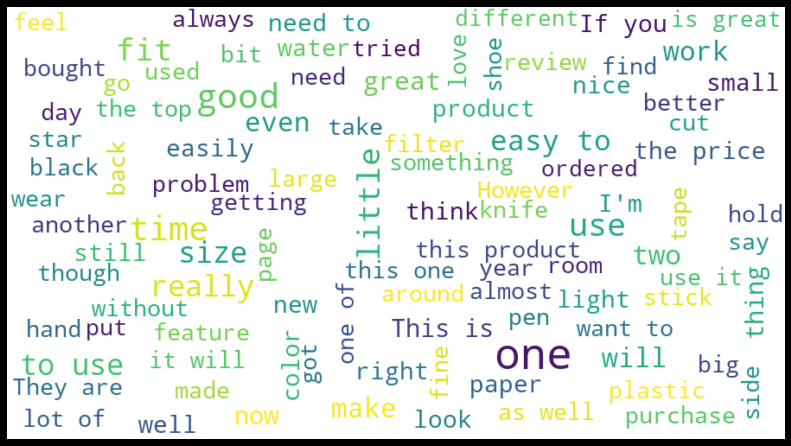

In [32]:
plot_word_cloud(wordcloud)

Como se puede observar en la nube de palaras hay muchas palabras que no apartan información para discernir topics, como good, look, little, etc. razón por las que se decide eliminar

In [33]:
words = set(review_text.split())

In [34]:
print(f'Número de palabras distintas {len(words)}')

Número de palabras distintas 15204


In [35]:
from statistics import mean
print(f'Longitud media de las palabras {mean([len(w) for w in words])}')

Longitud media de las palabras 7.077282294133123


In [36]:
print(f'Longitud máxima de las palabras {max([len(w) for w in words])}')

Longitud máxima de las palabras 132


In [37]:
print(f'Palabra con longitud máxima {max(words, key=len)}')

Palabra con longitud máxima there.------------------------------------------------------------------------------------------------------------------------UPDATE


Como se puede apreciar, la palabra más larga se trata de un texto especial. Se podría hacer un análisis posterior para procesar todo este tipo de casuísticas en la que varias palabras se unen con dististintos caracteres, como /, -, _, etc.

In [38]:
print(f'Longitud mínima de las palabras {min([len(w) for w in words])}')

Longitud mínima de las palabras 1


En nuestra función de preprocesado se eliminan, por defecto, las palabras con longitud menor a tres y mayor a 30 caracteres.

### 3.2.2 Creación de datos: tokens, dicccionario y corpus

In [39]:
processed_texts = get_processed_texts(reviews)
dictionary = get_dictionary(processed_texts)
corpus = get_corpus(dictionary, processed_texts)

In [40]:
len(dictionary.items())

2214

### 3.2.3 Selección del modelo óptimo

In [41]:
# crear diferentes modelos según el número de topics y calcular el coherence de cada uno de ellos
def compute_models_and_coherences(dictionary, corpus, texts, limit, start=2, step=1, passes=10, iterations=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Crear modelo LDA
        # TODO: Probar con más parámetros del LdaModel, como
        #  - alpha -> pro ejemplo, list(np.arange(0.1, 1, 0.3), añadiendo symmetric y asymmetric
        #  - beta -> list(np.arange(0.1, 1, 0.3)) añadiendo symmetric
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=passes,
                                                iterations=iterations,
                                                alpha='auto')
        
        # Añadir el modelo a la lista de modelos
        model_list.append(model)
        
        # Calcular el coherence del modelo
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
start = 3
end = 9
step = 1

In [49]:
%%time
model_list, coherence_values = compute_models_and_coherences(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start,
    limit=end,
    step=step
)

CPU times: user 29.7 s, sys: 423 ms, total: 30.1 s
Wall time: 30.8 s


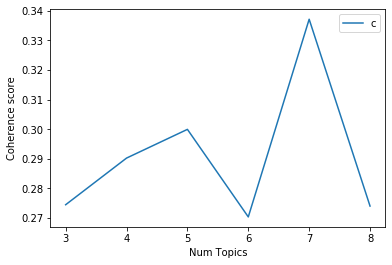

In [50]:
# Pintamos los resultados para ver cuál es el número de topics que proporciona el mejor coherence
x = range(start, end, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

## 3.3 Análisis de los resultados obtenidos

El gráfico resultando muestra que el mejor modelo obtenido, de acuerdo a su coherence, es de 7 topics. No obstante, nosotros sabemos que hay 5 topics bien definidos porque hemos creado el dataset final a parti de la mezcla de los datos de 5 dataset relativos cada uno a un tema. Así pues, vamos a analizar el modelo correspondiente a 7 topics y el de 5 topics.

A continuación, definimos las funciones generales comunes para el análisis de los resultados obtenidos.

In [51]:
def get_perplexity(lda_model, corpus):
    return lda_model.log_perplexity(corpus)

In [52]:
def get_coherence(lda_model, texts, dictionary):
    return CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()

In [53]:
def get_tokens_by_topic_df(lda_model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = lda_model.show_topic(i, topn = 20)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [54]:
def format_topics_sentences(lda_model, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [55]:
def get_dominant_topics_df(df_topic_sents_keywords):
    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    return df_dominant_topic

In [56]:
def get_sorted_sent_topics_df(df_dominant_topics):
    sorted_sent_topics = pd.DataFrame()

    sorted_sent_topics_grpd = df_dominant_topics.groupby('Dominant_Topic')

    for i, grp in sorted_sent_topics_grpd:
        sorted_sent_topics = pd.concat([
            sorted_sent_topics,
            grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
            axis=0)

    # Reset Index    
    sorted_sent_topics.reset_index(drop=True, inplace=True)

    # Format
    sorted_sent_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    return sorted_sent_topics

In [57]:
def get_topic_contribution_df(df_dominant_topics):
    # Number of Documents for Each Topic
    topic_counts = df_dominant_topics['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
    topic_contribution_df = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
    topic_contribution_df.reset_index(drop=True, inplace=True)

    return topic_contribution_df

### 3.3.1 Análisis modelo de 7 topics

In [58]:
num_topics = 7
optimal_model_idx = num_topics - start
optimal_model_idx

4

#### 3.3.1.1 Perplexity and Coherence

In [59]:
optimal_model = model_list[optimal_model_idx]

In [60]:
print('Perplexity (cuanto más bajo, mejor)', get_perplexity(optimal_model, corpus))
print('Coherence Score: ', get_coherence(optimal_model, processed_texts, dictionary))

Perplexity (cuanto más bajo, mejor) -7.494072107735615
Coherence Score:  0.3371269078855285


#### 3.3.1.2 Token de cada topic

In [61]:
# Mostrar los topics
optimal_model.show_topics()

[(0,
  '0.015*"filter" + 0.013*"pad" + 0.013*"car" + 0.012*"use" + 0.012*"phone" + 0.011*"water" + 0.007*"handle" + 0.006*"small" + 0.006*"wax" + 0.006*"oil"'),
 (1,
  '0.017*"use" + 0.011*"work" + 0.010*"water" + 0.009*"doe" + 0.009*"bottle" + 0.008*"lot" + 0.007*"small" + 0.007*"case" + 0.006*"bought" + 0.006*"product"'),
 (2,
  '0.014*"knife" + 0.012*"use" + 0.009*"box" + 0.009*"color" + 0.008*"perfect" + 0.007*"bought" + 0.007*"wear" + 0.006*"comfortable" + 0.006*"work" + 0.006*"fit"'),
 (3,
  '0.019*"fit" + 0.010*"size" + 0.010*"shoe" + 0.009*"wear" + 0.009*"ordered" + 0.007*"sock" + 0.006*"staple" + 0.006*"thing" + 0.006*"pair" + 0.006*"product"'),
 (4,
  '0.023*"use" + 0.009*"work" + 0.008*"folder" + 0.008*"fit" + 0.008*"label" + 0.007*"file" + 0.007*"tab" + 0.006*"easily" + 0.006*"wheel" + 0.006*"clay"'),
 (5,
  '0.021*"product" + 0.019*"use" + 0.008*"set" + 0.008*"bag" + 0.008*"quality" + 0.007*"size" + 0.007*"note" + 0.007*"tray" + 0.006*"thing" + 0.006*"machine"'),
 (6,
  '0

In [62]:
tokens_by_topic_df = get_tokens_by_topic_df(optimal_model, num_topics)
tokens_by_topic_df

Topic #01 Topic #02    Topic #03    Topic #04  Topic #05 Topic #06  \
0     filter       use        knife          fit        use   product   
1        pad      work          use         size       work       use   
2        car     water          box         shoe     folder       set   
3        use       doe        color         wear        fit       bag   
4      phone    bottle      perfect      ordered      label   quality   
5      water       lot       bought         sock       file      size   
6     handle     small         wear       staple        tab      note   
7      small      case  comfortable        thing     easily      tray   
8        wax    bought         work         pair      wheel     thing   
9        oil   product          fit      product       clay   machine   
10     mouse       fit     material          way      sheet      work   
11       cup     carry         hand  comfortable       card       lot   
12       pan   problem          job         tape       size   plastic   
13       air      year      quality        happy      color   looking   
14      food      deal          day          big        doe      want   
15      year   perfect        shirt       amazon  different    pencil   
16   product    carpet         feel          leg        bag    weight   
17   problem    worked          buy         foot       long       ice   
18    design      jeep          cap         tire       fuel       fit   
19     clean      took        right         come       want      come   

    Topic #07  
0     printer  
1       paper  
2        work  
3         ink  
4       light  
5       print  
6         use  
7         pen  
8       color  
9         set  
10  cartridge  
11      think  
12    install  
13       year  
14      canon  
15      epson  
16    product  
17    quality  
18   printing  
19       know

In [63]:
# visualizamos los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.061137  0.017563       1        1  15.931587
6     -0.046716 -0.085106       2        1  15.925974
0     -0.070820  0.130682       3        1  15.776237
3      0.146786  0.017864       4        1  15.179445
5     -0.033470 -0.001830       5        1  12.806962
4     -0.018843 -0.077611       6        1  12.519140
1     -0.038075 -0.001561       7        1  11.860651, topic_info=             Term        Freq       Total Category  logprob  loglift
1703      printer  103.000000  103.000000  Default  30.0000  30.0000
147        filter   82.000000   82.000000  Default  29.0000  29.0000
1701          ink   80.000000   80.000000  Default  28.0000  28.0000
2081        knife   84.000000   84.000000  Default  27.0000  27.0000
79            pad   84.000000   84.000000  Default  26.0000  26.0000
274         water  110.000000  110.000000  Default  25.0000  25.0000
692         paper  119.000000  119.000000  Default  24.0000  24.0000
1651        print   74.000000   74.000000  Default  23.0000  23.0000
801         phone   80.000000   80.000000  Default  22.0000  22.0000
1711       folder   36.000000   36.000000  Default  21.0000  21.0000
1288         wear   93.000000   93.000000  Default  20.0000  20.0000
13        product  222.000000  222.000000  Default  19.0000  19.0000
148           fit  227.000000  227.000000  Default  18.0000  18.0000
16            use  437.000000  437.000000  Default  17.0000  17.0000
20            car  101.000000  101.000000  Default  16.0000  16.0000
1801          pen   61.000000   61.000000  Default  15.0000  15.0000
1710         file   32.000000   32.000000  Default  14.0000  14.0000
464          shoe   73.000000   73.000000  Default  13.0000  13.0000
78        ordered   57.000000   57.000000  Default  12.0000  12.0000
1700    cartridge   43.000000   43.000000  Default  11.0000  11.0000
69         bottle   44.000000   44.000000  Default  10.0000  10.0000
225         light  105.000000  105.000000  Default   9.0000   9.0000
1926       staple   32.000000   32.000000  Default   8.0000   8.0000
204           set   95.000000   95.000000  Default   7.0000   7.0000
1367         sock   38.000000   38.000000  Default   6.0000   6.0000
1811          tab   37.000000   37.000000  Default   5.0000   5.0000
1889        mouse   30.000000   30.000000  Default   4.0000   4.0000
1702        label   46.000000   46.000000  Default   3.0000   3.0000
397           box   80.000000   80.000000  Default   2.0000   2.0000
558           bag   71.000000   71.000000  Default   1.0000   1.0000
1416          bra   20.782656   22.606920   Topic1  -5.5276   1.7527
1212     securely    9.943694   11.290181   Topic1  -6.2648   1.7099
2195        mixer   14.026587   15.993418   Topic1  -5.9208   1.7056
2173       carafe    8.020489    9.407661   Topic1  -6.4797   1.6773
1183          cap   24.832840   29.213549   Topic1  -5.3495   1.6744
1060          sun    7.180740    8.466744   Topic1  -6.5903   1.6721
1466        skirt    6.368625    7.530132   Topic1  -6.7103   1.6693
1059       summer   14.307067   16.920868   Topic1  -5.9010   1.6691
46         helmet    4.751974    5.643515   Topic1  -7.0032   1.6649
2081        knife   71.245331   84.741447   Topic1  -4.2956   1.6634
1511      pendant    4.723924    5.643376   Topic1  -7.0091   1.6590
2156         hair    6.212242    7.525906   Topic1  -6.7352   1.6450
1733       bubble    4.636782    5.639933   Topic1  -7.0277   1.6410
1764         self    6.918908    8.475991   Topic1  -6.6275   1.6339
2089       bullet    3.833302    4.700320   Topic1  -7.2180   1.6330
1539         sexy    3.829992    4.702427   Topic1  -7.2189   1.6317
770        cotton    6.894507    8.465446   Topic1  -6.6310   1.6316
1691    dispenser    8.411364   10.343496   Topic1  -6.4321   1.6301
1029       curved    3.816973    4.702703   Topic1  -7.2223   1.6282
1415        shirt   2

In [64]:
pyLDAvis.save_html(vis, 'results/topics_vis_7.html')

#### 3.3.1.3 Topic dominante por texto

In [65]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus, processed_texts)
dominant_topics_df = get_dominant_topics_df(df_topic_sents_keywords)
dominant_topics_df.head(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             1.0              0.5699   
1             1             4.0              0.5961   
2             2             0.0              0.4774   
3             3             0.0              0.3977   
4             4             4.0              0.2953   
5             5             6.0              0.3644   
6             6             1.0              0.2821   
7             7             1.0              0.7537   
8             8             4.0              0.2230   
9             9             0.0              0.8407   
10           10             3.0              0.7228   
11           11             1.0              0.3097   
12           12             1.0              0.3121   
13           13             0.0              0.2938   
14           14             0.0              0.4071   
15           15             1.0              0.5594   
16           16             1.0              0.3856   
17           17             6.0              0.2744   
18           18             3.0              0.6272   
19           19             1.0              0.8068   

                                             Keywords  \
0   use, work, water, doe, bottle, lot, small, cas...   
1   use, work, folder, fit, label, file, tab, easi...   
2   filter, pad, car, use, phone, water, handle, s...   
3   filter, pad, car, use, phone, water, handle, s...   
4   use, work, folder, fit, label, file, tab, easi...   
5   printer, paper, work, ink, light, print, use, ...   
6   use, work, water, doe, bottle, lot, small, cas...   
7   use, work, water, doe, bottle, lot, small, cas...   
8   use, work, folder, fit, label, file, tab, easi...   
9   filter, pad, car, use, phone, water, handle, s...   
10  fit, size, shoe, wear, ordered, sock, staple, ...   
11  use, work, water, doe, bottle, lot, small, cas...   
12  use, work, water, doe, bottle, lot, small, cas...   
13  filter, pad, car, use, phone, water, handle, s...   
14  filter, pad, car, use, phone, water, handle, s...   
15  use, work, water, doe, bottle, lot, small, cas...   
16  use, work, water, doe, bottle, lot, small, cas...   
17  printer, paper, work, ink, light, print, use, ...   
18  fit, size, shoe, wear, ordered, sock, staple, ...   
19  use, work, water, doe, bottle, lot, small, cas...   

                                                 Text  
0   [unit, eliminates, gauge, job, quicker, accura...  
1   [product, use, sure, going, drive, hour, wheel...  
2   [excellent, scanner, capable, reading, wheel, ...  
3   [power, madd, clip, broke, decided, try, echo,...  
4   [best, cleaner, far, recently, changed, brake,...  
5   [bought, replace, alligator, clip, went, walk,...  
6                                 [worked, perfectly]  
7   [jeep, mile, product, month, ago, product, wor...  
8          [level, camper, eye, sight, work, install]  
9   [cabin, air, filter, definitely, value, qualit...  
10  [bought, year, ago, primarily, battery, backup...  
11  [bought, gift, husband, jeep, wrangler, came, ...  
12          [said, basically, money, want, kind, way]  
13  [spaying, rubber, seal, stick, open, close, ho...  
14  [meguiar, detailers, past, hooked, final, insp...  
15  [ordered, discovered, wouldn, hold, reading, h...  
16  [said, flimsy, piece, plastic, brass, blade, e...  
17  [pro, read, rubber, line, flexible, bleed, val...  
18  [rating, product, star, draw, attention, revie...  
19  [leather, sofa, seat, chair, ottoman, faded, l...

#### 3.3.1.4 Documento más represetantivo por topic

In [66]:
sorted_sent_topics_df = get_sorted_sent_topics_df(df_topic_sents_keywords)
sorted_sent_topics_df

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9266   
1        1.0              0.8502   
2        2.0              0.8406   
3        3.0              0.9246   
4        4.0              0.9532   
5        5.0              0.8788   
6        6.0              0.9297   

                                            Keywords  \
0  filter, pad, car, use, phone, water, handle, s...   
1  use, work, water, doe, bottle, lot, small, cas...   
2  knife, use, box, color, perfect, bought, wear,...   
3  fit, size, shoe, wear, ordered, sock, staple, ...   
4  use, work, folder, fit, label, file, tab, easi...   
5  product, use, set, bag, quality, size, note, t...   
6  printer, paper, work, ink, light, print, use, ...   

                                                Text  
0  [zte, valet, tracfone, verizon, tower, android...  
1  [introi, purchased, plastic, polish, kit, clea...  
2  [cat, large, golden, retriever, mix, dog, natu...  
3  [rack, month, including, short, long, trip, br...  
4  [eighteen, year, standrd, green, pendaflex, fi...  
5  [answering, machine, fact, bought, actual, tap...  
6  [wireless, printer, shared, home, office, netw...

#### 3.3.1.5 Distribución de topics en el corpus

In [67]:
topic_contribution_df = get_topic_contribution_df(df_topic_sents_keywords)
topic_contribution_df

topic  contribution
0    2.0         0.194
1    3.0         0.194
2    6.0         0.148
3    0.0         0.124
4    4.0         0.122
5    1.0         0.116
6    5.0         0.102

In [68]:
sorted_topic_contribution_df = topic_contribution_df.sort_values('topic')
sorted_topic_contribution_df

topic  contribution
3    0.0         0.124
5    1.0         0.116
0    2.0         0.194
1    3.0         0.194
4    4.0         0.122
6    5.0         0.102
2    6.0         0.148

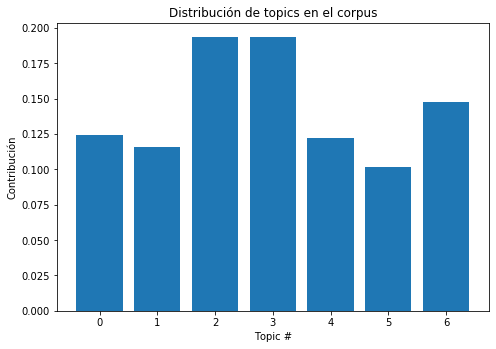

In [69]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_topic_contribution_df['topic'], sorted_topic_contribution_df['contribution'])
plt.xlabel('Topic #')
plt.ylabel('Contribución')
plt.title("Distribución de topics en el corpus")
plt.show()

#### 3.3.1.6 Conclusiones con 7 topics

Revisando por encima los datos obtenidos y la información visual que aportan los gráficos, vemos que los 7 topics más o menos tienen la misma importancia en todo el corpus, ya que la diferencia entre ellos no es muy grande. Visualmente se llega a esta conclusión con la altura de la barras en el gráfico de barras, así como con el radio de los círculos en el gráfico obtenido con la herramienta pyLDavis; tanto las alturas, como los radios entre sí son muy parecidos.

Supuestamente no sabemos los topics de las reviews analizadas y por ello, a priori, deberíamos concluir que la información tratada en las reviews, aparentemente, versa sobre siete temas o categorías diferentes. Sin embargo, nosotros sabemos de antemano que hay cinco categorías bien diferencias y, por tanto, lo lógico es pensar que al haber obtenido siete categorías, al menos dos de ellas son subcategorías de otras o hay mezcla de temas dentro del mismo topic.

Podemos realizar un estudio más detenido revisando los valores numéricos obtenidos, pero es más intuitivo y rápido el análisis del gráfico pyLDavis. Para ello vamos a ir seleccionando por orden cada círculo y analizando los tokens que lo conforman. Hay que advertir que el número identificador de topic de pyLDavis no coinciden con los mostrados en las tablas de datos y/o en el gráfico de barra, pero sí los tokens de cada topic. 

- Topic 1: Vemos que las palabras que lo conforman son knife, use, box, color, perfect. Si ordenamos las palabras relevancia con un λ=0.4, vemos que los tokens que mejor definen al topic son knife, box, shirt, cap, bra, material, dress, comfortable, etc. Exceptuando knife, parece que el topic es relativo a ropa.
- Topic 2: Procediendo del mismo modo que en el topic 1, con un λ=0.4, observamos que las palabras más relevantes son printer, ink, papel, print, pen, cartridge, etc. Por tanto el topic es material de oficina.
- Topic 3: Este topic es el más alejado del resto dentro del gráfico, por lo que debería estar bien diferenciado, aunque analizando sus datos, no vemos que sea ese el caso. Hay que tener en cuenta que esta distancia es sólo en dos dimensiones dadas (se ha reducido la dimensionalidad con PCA a 2), y, por tanto, se han eliminado otras características. Con la misma restricción de landa, vemos que las palabras más influyentes son filter, pad, car, wax, etc. Vemos al final de la lista, pero prácticamente todo en rojo, lo que indica que está muy relacionado con este topic, la palabra meguiar. Meguiar es una marca de cera en spray para coches. Por tanto, es claro que este topic está relacionado con la categoría Automotive. Sin embargo, hay otras palabras que también influyen, como cooker, foor, jar, etc. que nos hacen pensar que también está relacionado, aunque en menor medida, con Home y Kitchen.
- Topic 4: Este topic es bastante confuso. Incluso bajando a λ=0.2 vemos que hay mezcla de palabras. Por un lado vemos que influyen mucho sock, boot, shoe, pant, etc.,  que nos lleva a pensar en ropa y zapatos. También se observan los tokens staple, stapler, wingline (puerta corredera en armarios) etc. que indican oficina. Asimismo tenemos wiper (limpiaparabrisas), bolt, etc. que nos lleva a pensar en coches; per también están hunting (caza y deportes al aire libre) y earring (pendiente), con el tema de joyería. Este topic está muy difuso aunque parece que prevalece la ropa, aunque no tan fuerte como en el topic 1.
- Topic 5: en este caso las palabras que más influyen con λ=0.2 son ice, meat, tea, mug, fruit, fridge, iron, etc. que nos dan a entender topic de cocina. Podríamos decir que es un subgénero de la categoría Home & Kitchen, más centrado en cocina. Sin embargo, vemos también palabras como pencil, fan, monitor, etc. que nos lleva a pensar en material de oficina. La importancia de estas palabras son de menor intensidad.
- Topic 6: este topic está solapado gráficamente con el 2. Hay palabras de todo tipo aunque destacan en cierta medidas las de coches: fuel, wheel,mph, etc. Pero también, en la misma medida, hay palabras de casa o cocina, como mirror, salt, oven. también hay palabras de oficina como folder o file.
- Topic 7: este topic está solapado gráficamente con el 5. Hay palabras relacionadas con casa como carpet, bottle, chair, etc. Pero también hay palabras relacionadas con coches, como jeep. Aparece rifle que podríamos relacionarlo con deportes al aire libre.

Han aparecido en los topics las categorías que ya sabíamos de antemano, pero no ha destacado en ningún topic de forma clara la categoría de Sport & Outdoors.

### 3.3.2 Análisis modelo de 5 topics

Los cinco topics con los que estamos trabajando son:

- Automotive
- Clothing Shoes and Jewelry
- Home and Kitchen
- Office Products
- Sports and Outdoors

In [70]:
num_topics = 5
optimal_model_idx = num_topics - start
optimal_model_idx

2

#### 3.3.2.1 Perplexity and Coherence

In [71]:
optimal_model = model_list[optimal_model_idx]

In [72]:
print('Perplexity (cuanto más bajo, mejor)', get_perplexity(optimal_model, corpus))
print('Coherence Score: ', get_coherence(optimal_model, processed_texts, dictionary))

Perplexity (cuanto más bajo, mejor) -7.42911029569388
Coherence Score:  0.2999327232024119


#### 3.3.2.2 Token de cada topic

In [73]:
# Mostrar los topics
optimal_model.show_topics()

[(0,
  '0.011*"phone" + 0.010*"use" + 0.009*"ink" + 0.008*"pen" + 0.007*"knife" + 0.007*"right" + 0.007*"box" + 0.006*"screen" + 0.006*"machine" + 0.005*"work"'),
 (1,
  '0.019*"fit" + 0.011*"use" + 0.010*"size" + 0.009*"wear" + 0.008*"pad" + 0.006*"note" + 0.006*"tape" + 0.006*"work" + 0.006*"ordered" + 0.005*"stick"'),
 (2,
  '0.009*"shoe" + 0.008*"bag" + 0.008*"color" + 0.007*"fit" + 0.007*"big" + 0.007*"printer" + 0.007*"small" + 0.006*"got" + 0.006*"work" + 0.005*"lot"'),
 (3,
  '0.027*"use" + 0.015*"work" + 0.014*"product" + 0.009*"paper" + 0.008*"water" + 0.006*"label" + 0.006*"car" + 0.005*"cup" + 0.005*"printer" + 0.005*"size"'),
 (4,
  '0.013*"use" + 0.011*"year" + 0.011*"filter" + 0.010*"light" + 0.009*"doe" + 0.009*"battery" + 0.008*"product" + 0.008*"quality" + 0.007*"work" + 0.007*"car"')]

In [74]:
tokens_by_topic_df = get_tokens_by_topic_df(optimal_model, num_topics)
tokens_by_topic_df

Topic #01 Topic #02    Topic #03 Topic #04  Topic #05
0       phone       fit         shoe       use        use
1         use       use          bag      work       year
2         ink      size        color   product     filter
3         pen      wear          fit     paper      light
4       knife       pad          big     water        doe
5       right      note      printer     label    battery
6         box      tape        small       car    product
7      screen      work          got       cup    quality
8     machine   ordered         work   printer       work
9        work     stick          lot      size        car
10      color   product         size      come        air
11      thing     color          use     thing     bought
12        bit      inch      perfect    folder      water
13  cartridge      come      problem     small    looking
14       hold    coffee        think     think       want
15    product   quality          new      clay       unit
16        buy    bought     material      sure      knife
17        set       tab  comfortable       fit       high
18       want       doe         unit       bit     review
19       page   perfect         long      file  purchased

In [75]:
# visualizamos los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.078629 -0.071571       1        1  21.950127
0      0.005309  0.089227       2        1  20.116297
4     -0.069711 -0.045843       3        1  19.922531
3     -0.069199 -0.003291       4        1  19.579758
2      0.054973  0.031478       5        1  18.431293, topic_info=             Term        Freq       Total Category  logprob  loglift
147        filter   81.000000   81.000000  Default  30.0000  30.0000
801         phone   81.000000   81.000000  Default  29.0000  29.0000
148           fit  227.000000  227.000000  Default  28.0000  28.0000
85        battery   72.000000   72.000000  Default  27.0000  27.0000
1801          pen   61.000000   61.000000  Default  26.0000  26.0000
16            use  438.000000  438.000000  Default  25.0000  25.0000
464          shoe   72.000000   72.000000  Default  24.0000  24.0000
1701          ink   80.000000   80.000000  Default  23.0000  23.0000
79            pad   84.000000   84.000000  Default  22.0000  22.0000
1288         wear   92.000000   92.000000  Default  21.0000  21.0000
558           bag   72.000000   72.000000  Default  20.0000  20.0000
843        screen   49.000000   49.000000  Default  19.0000  19.0000
2081        knife   84.000000   84.000000  Default  18.0000  18.0000
1702        label   47.000000   47.000000  Default  17.0000  17.0000
225         light  104.000000  104.000000  Default  16.0000  16.0000
13        product  221.000000  221.000000  Default  15.0000  15.0000
1703      printer  102.000000  102.000000  Default  14.0000  14.0000
132           air   47.000000   47.000000  Default  13.0000  13.0000
20            car  100.000000  100.000000  Default  12.0000  12.0000
174          year  140.000000  140.000000  Default  11.0000  11.0000
733          clay   27.000000   27.000000  Default  10.0000  10.0000
2132       coffee   44.000000   44.000000  Default   9.0000   9.0000
397           box   80.000000   80.000000  Default   8.0000   8.0000
2184          pan   29.000000   29.000000  Default   7.0000   7.0000
932           cup   49.000000   49.000000  Default   6.0000   6.0000
457          note   63.000000   63.000000  Default   5.0000   5.0000
520          horn   23.000000   23.000000  Default   4.0000   4.0000
274         water  110.000000  110.000000  Default   3.0000   3.0000
1811          tab   38.000000   38.000000  Default   2.0000   2.0000
692         paper  118.000000  118.000000  Default   1.0000   1.0000
2184          pan   27.507227   29.383795   Topic1  -5.5677   1.4504
1819          jar   12.936079   14.207758   Topic1  -6.3222   1.4226
1453         cute   16.379766   18.923597   Topic1  -6.0861   1.3720
1616         post   27.740768   32.182972   Topic1  -5.5593   1.3679
2182    calphalon    5.679432    6.625369   Topic1  -7.1453   1.3623
1439        build    4.829793    5.677424   Topic1  -7.3074   1.3547
1694       scotch   10.452367   12.304868   Topic1  -6.5354   1.3532
1214       failed    4.776760    5.676753   Topic1  -7.3184   1.3438
1741     laminate    6.360422    7.567391   Topic1  -7.0321   1.3426
1919      teacher    4.738494    5.676612   Topic1  -7.3265   1.3358
290         brass    6.250835    7.567668   Topic1  -7.0495   1.3252
2174       french    7.026116    8.513252   Topic1  -6.9325   1.3244
2142        scope    6.995967    8.512649   Topic1  -6.9368   1.3202
2132       coffee   36.471783   44.482197   Topic1  -5.2856   1.3178
1811          tab   31.782774   38.773560   Topic1  -5.4233   1.3176
1646       firmly    4.649095    5.673720   Topic1  -7.3455   1.3172
1815     organize    3.866250    4.728527   Topic1  -7.5299   1.3151
1022     leveling    3.852715    4.727391   Topic1  -7.5334   1.3118
1380        usual    4.594269    5.671001   Topic1  -7.3574   1.3058
1606     military    3.824473    4.727128   Topic1  -7.5408   1.3045
1836     reminder    5.310918    6.619098   Topic1  -7.2124 

In [76]:
pyLDAvis.save_html(vis, 'results/topics_vis_5.html')

#### 3.3.2.3 Topic dominante por texto

In [77]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus, processed_texts)
dominant_topics_df = get_dominant_topics_df(df_topic_sents_keywords)
dominant_topics_df.head(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             1.0              0.2914   
1             1             3.0              0.6930   
2             2             2.0              0.5978   
3             3             1.0              0.2485   
4             4             3.0              0.7131   
5             5             4.0              0.6833   
6             6             1.0              0.2874   
7             7             3.0              0.3341   
8             8             1.0              0.2973   
9             9             4.0              0.8680   
10           10             4.0              0.7386   
11           11             2.0              0.4389   
12           12             2.0              0.2484   
13           13             4.0              0.2701   
14           14             4.0              0.4662   
15           15             4.0              0.3696   
16           16             1.0              0.5404   
17           17             4.0              0.3678   
18           18             1.0              0.6636   
19           19             3.0              0.4910   

                                             Keywords  \
0   fit, use, size, wear, pad, note, tape, work, o...   
1   use, work, product, paper, water, label, car, ...   
2   shoe, bag, color, fit, big, printer, small, go...   
3   fit, use, size, wear, pad, note, tape, work, o...   
4   use, work, product, paper, water, label, car, ...   
5   use, year, filter, light, doe, battery, produc...   
6   fit, use, size, wear, pad, note, tape, work, o...   
7   use, work, product, paper, water, label, car, ...   
8   fit, use, size, wear, pad, note, tape, work, o...   
9   use, year, filter, light, doe, battery, produc...   
10  use, year, filter, light, doe, battery, produc...   
11  shoe, bag, color, fit, big, printer, small, go...   
12  shoe, bag, color, fit, big, printer, small, go...   
13  use, year, filter, light, doe, battery, produc...   
14  use, year, filter, light, doe, battery, produc...   
15  use, year, filter, light, doe, battery, produc...   
16  fit, use, size, wear, pad, note, tape, work, o...   
17  use, year, filter, light, doe, battery, produc...   
18  fit, use, size, wear, pad, note, tape, work, o...   
19  use, work, product, paper, water, label, car, ...   

                                                 Text  
0   [unit, eliminates, gauge, job, quicker, accura...  
1   [product, use, sure, going, drive, hour, wheel...  
2   [excellent, scanner, capable, reading, wheel, ...  
3   [power, madd, clip, broke, decided, try, echo,...  
4   [best, cleaner, far, recently, changed, brake,...  
5   [bought, replace, alligator, clip, went, walk,...  
6                                 [worked, perfectly]  
7   [jeep, mile, product, month, ago, product, wor...  
8          [level, camper, eye, sight, work, install]  
9   [cabin, air, filter, definitely, value, qualit...  
10  [bought, year, ago, primarily, battery, backup...  
11  [bought, gift, husband, jeep, wrangler, came, ...  
12          [said, basically, money, want, kind, way]  
13  [spaying, rubber, seal, stick, open, close, ho...  
14  [meguiar, detailers, past, hooked, final, insp...  
15  [ordered, discovered, wouldn, hold, reading, h...  
16  [said, flimsy, piece, plastic, brass, blade, e...  
17  [pro, read, rubber, line, flexible, bleed, val...  
18  [rating, product, star, draw, attention, revie...  
19  [leather, sofa, seat, chair, ottoman, faded, l...

#### 3.3.2.4 Documento más represetantivo por topic

In [78]:
sorted_sent_topics_df = get_sorted_sent_topics_df(df_topic_sents_keywords)
sorted_sent_topics_df

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9328   
1        1.0              0.9220   
2        2.0              0.8727   
3        3.0              0.9244   
4        4.0              0.8935   

                                            Keywords  \
0  phone, use, ink, pen, knife, right, box, scree...   
1  fit, use, size, wear, pad, note, tape, work, o...   
2  shoe, bag, color, fit, big, printer, small, go...   
3  use, work, product, paper, water, label, car, ...   
4  use, year, filter, light, doe, battery, produc...   

                                                Text  
0  [zte, valet, tracfone, verizon, tower, android...  
1  [highland, product, highland, brand, sell, pro...  
2  [bought, horn, replace, weak, sounding, horn, ...  
3  [mercedes, benz, mile, idle, rough, noisy, eng...  
4  [owned, light, year, light, serf, camping, red...

#### 3.3.2.5 Distribución de topics en el corpus

In [79]:
topic_contribution_df = get_topic_contribution_df(df_topic_sents_keywords)
topic_contribution_df

topic  contribution
0    1.0         0.334
1    4.0         0.212
2    2.0         0.166
3    3.0         0.156
4    0.0         0.132

In [80]:
sorted_topic_contribution_df = topic_contribution_df.sort_values('topic')
sorted_topic_contribution_df

topic  contribution
4    0.0         0.132
0    1.0         0.334
2    2.0         0.166
3    3.0         0.156
1    4.0         0.212

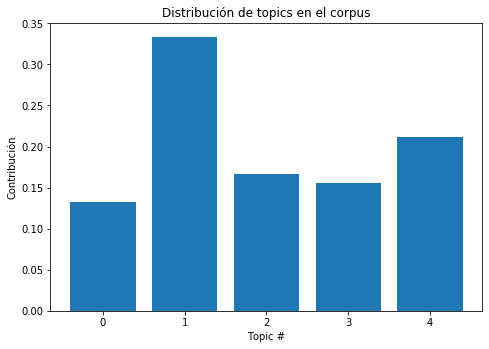

In [81]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_topic_contribution_df['topic'], sorted_topic_contribution_df['contribution'])
plt.xlabel('Topic #')
plt.ylabel('Contribución')
plt.title("Distribución de topics en el corpus")
plt.show()

#### 3.3.2.6 Conclusiones con 5 topics

En este caso esperamos que los topics sí descubran las cinco categorías que ya sabemos de antemano. El radio de los círculos y la altura de las barras son muy parecidas, y prácticamente todos los topics aparecen más o menos igual. No obstante, en este caso sí que hay un topic que destaca ligeramente sobre el resto que es el 1 en la barras, que equivale al 2 en pyLDAvis.

Procederemos a analizar el gráfico pyLDAvis como en el caso de los 7 topics, con distintos valores de λ. También podemos centrarnos en la influencia de determinados tokens, si así lo decidimos.

- Topic 1: las palabras más influyentes son pan, jar, coffee, food, meat, dishwasher, etc. que están relacionadas con la cocina. También hay palabras como mouse, sticky, tape, que están relacionadas con la oficina. Asimismo hay palabras sueltas como wear, ring, boot, etc. que están relacionados con la ropa y joyería. Vemos que es un topic con varias categorías, aunque la más influyente pueda ser cocina.
- Topic 2: en este caso las palabras están más claras y son phone, pen, screen, ink, app, cartridge, etc. que están relacionadas con material de oficina. Hay alguna palabra suelta relacionada en menor medida con ropa, como sleeve, cap, shirt, bra, etc.
- Topic 3: en este topic destacan filter, battery, air, led, light, stainless, pressure, wiper, motocycle, etc., que denotan su relación con coches y automoción. Sin embargo, también están iron, oven, cooking, cooker, timer, bowl, etc. que están relacionadas con la cocina. También aparece de forma suelta coat, que no tiene mucha influencia.
- Topic 4: En este topic hay una mezcla de todas las categorías como carpet, bike, wheel, microwave, cleaner, sea, brake, seat, sponge, etc. Parecen estar todas las categorías menos la de oficina y deporte.
- Topic 5: Aquí también hay mezcla de palabras de prácticamente todas las categorías: horn, shoe, bag, strap, usb, skirt. No hay unas palabras que destaquen sobre las otras. Curiosamente, sí que aparece alguna palabra relacionada con deporte al aire libre o caza como rifle y pistol.

Se concluye que en esta clasificación no hay una separación clara de las distintas categorías tratadas en los topics obtenidos, aunque hay dos o tres topics en los que destaca alguna categoría sobre las demás. Los topics estaban más diferenciados en la solución de los 7 topics.

Aunque entre los resultados finales no se ha mostrado, sí hay que resaltar que este notebook ha tenido que ser ejecutado más de una vez debido a que inicialmente los tokens que más se repetían en los topics eran palabras como great, little, good, nice, etc., palabras que no ayudaban en nada a la diferenciación de topics. Esa es la razón por la que este tipo de palabras se han añadido como stopwords propios del notebook.
